In [3]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

# Настройки отображения графиков
%matplotlib inline
# Стили графиков -> обращайтесь в документацию по seaborn https://seaborn.pydata.org/generated/seaborn.set_style.html
plt.style.use('seaborn-whitegrid')
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)

In [4]:
# Считаем размер эффекта -> https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_effectsize.html
effect_size = sms.proportion_effectsize(0.13, 0.15)
# Cчитаем необходимый размер выборки -> https://www.statsmodels.org/dev/generated/statsmodels.stats.power.NormalIndPower.html?highlight=normalindpower
# https://www.statsmodels.org/dev/generated/statsmodels.stats.power.NormalIndPower.solve_power.html#statsmodels.stats.power.NormalIndPower.solve_power
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1) # Calculating sample size needed
# Округляем до ближайшего целого
required_n = ceil(required_n)
print("Для каждой группы нам необходимо не меньше ",required_n, " наблюдений")

Для каждой группы нам необходимо не меньше  4720  наблюдений


In [5]:
df = pd.read_csv('./ab_test_ensembles.csv')
df.head(15)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user
5,426f77eb-8739-43b6-999c-aecd14d9f346,2022-05-10 15:20:49.083499,control,standard,0,United Kingdom,42-49,registered_user
6,aa9d93c5-a18f-444a-a522-7e7145835362,2022-05-19 03:26:46.940749,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,registered_user
7,de214e30-9b8d-44cf-87b1-16917f3e1c89,2022-05-17 01:48:29.539573,control,standard,0,United Kingdom,18-25,registered_user
8,070f398e-e6bf-43e7-88bb-37eff2cb9212,2022-05-04 17:58:08.979471,treatment,svm_ensemble_v_1_22,1,United Kingdom,18-25,new_user
9,9cff0b7e-d42b-4508-9fbe-a4e74f7f29c5,2022-05-15 18:11:06.610965,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,new_user


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [7]:
# Убедимся, что контрольная группа и испытуемая видят старую страницу и новую -> https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html
pd.crosstab(df['group'], df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


In [8]:
sessions = df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")


У нас имеются 0 пользователей, которые не уникальны в нашей выборке.


In [9]:
#control_sample = df[df['group'] == 'control'].sample(n = required_n, random_state=42)
#treatment_sample = df[df['group'] == 'treatment'].sample(n = required_n, random_state=42)

# Сформируем общую случайную выборку
#ab_df = pd.concat([control_sample, treatment_sample], axis=0)
#ab_df.reset_index(drop=True, inplace=True)
#ab_df.head(15)

In [10]:
#ab_df.info()
#df.info()

In [11]:
#ab_df.group.value_counts(normalize=True)
#df.group.value_counts(normalize=True)

In [12]:
#conversion_rates = ab_df.groupby('group')['converted']
conversion_rates = df.groupby('group')['converted']

# Стандартное отклонение для сформированной выборки
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки, формулу стандартной ошибки вы знаете из лекций. Забыли - погуглите.
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.120399,0.325428,0.000848
treatment,0.118920,0.323694,0.000843


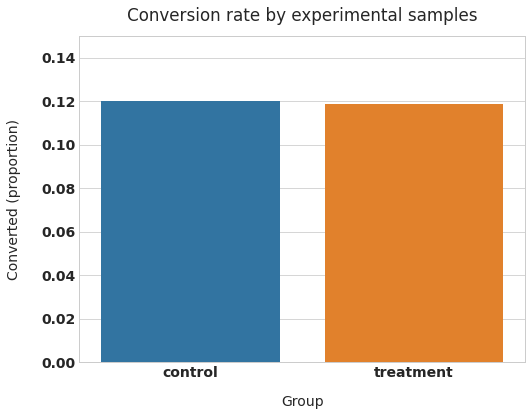

In [18]:
plt.figure(figsize=(8,6));
#sns.barplot(x=ab_df['group'], y=ab_df['converted'], ci=False);
sns.barplot(x=df['group'], y=df['converted'], ci=False);
plt.ylim(0, 0.15);
plt.title('Conversion rate by experimental samples', pad=15)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=20);


In [17]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

#control_results = ab_df[ab_df['group'] == 'control']['converted']
#treatment_results = ab_df[ab_df['group'] == 'treatment']['converted']


control_results = df[df['group'] == 'control']['converted']
treatment_results = df[df['group'] == 'treatment']['converted']


n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')


Z-statistic: 1.24
p-value: 0.216
CI 95% for control group: [0.119, 0.122]
CI 95% for treatment group: [0.117, 0.121]


ntcn


In [46]:
pd.crosstab(df['user_type'], df['variants'])

variants,standard,svm_ensemble_v_1_22
user_type,,
new_user,73797,73441
registered_user,73442,73798


In [47]:
sessions = df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")

У нас имеются 0 пользователей, которые не уникальны в нашей выборке.


In [48]:
df.group.value_counts(normalize=True)


treatment    0.500126
control      0.499874
Name: group, dtype: float64

In [49]:
#conversion_rates = ab_df.groupby('group')['converted']
conversion_rates = df.groupby('user_type')['converted']

# Стандартное отклонение для сформированной выборки
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки, формулу стандартной ошибки вы знаете из лекций. Забыли - погуглите.
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
user_type,,,
new_user,0.119154,0.323970,0.000844
registered_user,0.120164,0.325154,0.000847


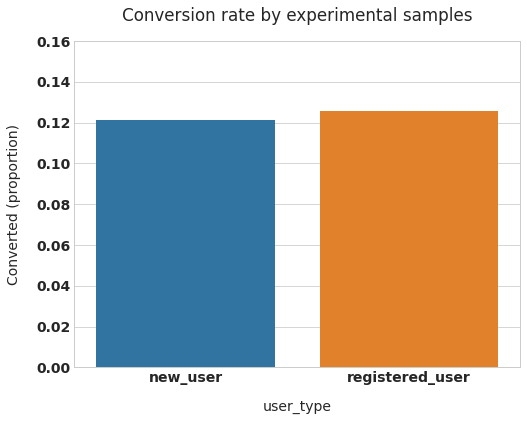

In [51]:
plt.figure(figsize=(8,6));
#sns.barplot(x=ab_df['group'], y=ab_df['converted'], ci=False);
sns.barplot(x=ab_df['user_type'], y=df['converted'], ci=False);
plt.ylim(0, 0.16);
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('user_type', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);


In [71]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

#control_results = ab_df[ab_df['group'] == 'control']['converted']
#treatment_results = ab_df[ab_df['group'] == 'treatment']['converted']


reg_user_results = df[df['user_type'] == 'registered_user']['converted']
new_user_results = df[df['user_type'] == 'new_user']['converted']


n_reg = reg_user_results.count()
n_new = new_user_results.count()
successes = [reg_user_results.sum(), new_user_results.sum()]
nobs = [n_reg, n_new]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_reg, lower_new), (upper_reg, upper_new) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for registered user: [{lower_reg:.3f}, {upper_reg:.3f}]')
print(f'CI 95% for new user: [{lower_new:.3f}, {upper_new:.3f}]')

Z-statistic: 0.84
p-value: 0.398
CI 95% for registered user: [0.119, 0.122]
CI 95% for new user: [0.117, 0.121]
